In [1]:
import numpy as np
import pandas as pd
import _pickle as cPickle
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
# append results to list

model_name = 'ActionIn-one_hot-1-4-20-3'

res_list = []
for res_folder in sorted(list(os.walk('../res'))[0][1]):
    if res_folder.startswith(model_name):
        try:
            with open(f'../res/{res_folder}/5000000.pkl', 'rb') as fp:
                res = cPickle.load(fp)
                res_list.append(res)
        except (FileNotFoundError, NotADirectoryError) as e:
                print(f"no pickle found for {res_folder}!")
print(f'file loaded! model count: {len(res_list)}')

no pickle found for ActionIn-one_hot-1-4-20-3-ce4474!
file loaded! model count: 14


In [84]:
res_list = res_list[:15]

In [90]:
def sample_games(hinter, guesser, samples=100, print_games=False, env=None):
    r_list = []
    if not env:
        env = hinter.env
    for _ in range(samples):
        obs_to_hinter = env.reset()
        hint_action = hinter.select_action(torch.tensor(obs_to_hinter, device=hinter.device), evaluate=True)
        obs_to_guesser, _, _, _ = env.step(hint_action.item())
        guess_action = guesser.select_action(torch.tensor(obs_to_guesser, device=hinter.device), evaluate=True)
        _, r, _, _ = env.step(guess_action)
        r_list += [r]
        if print_games:
            print(env.h1, env.h2, "target:", env.target, "hint", env.hint, "guess", env.guess, r)
    r_list = np.array(r_list)
    return np.sum(np.array(r_list) >= 0, axis=0) / r_list.shape[0]
    
def cross_play(res_list, samples=100):
    group_size = len(res_list)
    score_array = np.zeros((group_size, group_size))
    for i in range(group_size):
        for j in range(group_size):
            p1 = res_list[i]['p1']
            p2 = res_list[j]['p2']
            score_array[i][j] = sample_games(p1, p2, samples = samples)
            print(i, j, "score:", score_array[i][j])
    return score_array

In [82]:
# %%time
score_array = cross_play(res_list, samples=100)

0 0 score: 0.4
0 1 score: 0.28
0 2 score: 0.34
0 3 score: 0.36
0 4 score: 0.39
0 5 score: 0.33
0 6 score: 0.29
0 7 score: 0.29
0 8 score: 0.38
0 9 score: 0.32
0 10 score: 0.25
0 11 score: 0.4
0 12 score: 0.3
0 13 score: 0.45
0 14 score: 0.39
1 0 score: 0.36
1 1 score: 0.32
1 2 score: 0.4
1 3 score: 0.3
1 4 score: 0.33
1 5 score: 0.36
1 6 score: 0.4
1 7 score: 0.41
1 8 score: 0.42
1 9 score: 0.32
1 10 score: 0.42
1 11 score: 0.42
1 12 score: 0.43
1 13 score: 0.32
1 14 score: 0.36
2 0 score: 0.35
2 1 score: 0.42
2 2 score: 0.3
2 3 score: 0.41
2 4 score: 0.37
2 5 score: 0.31
2 6 score: 0.36
2 7 score: 0.4
2 8 score: 0.42
2 9 score: 0.29
2 10 score: 0.37
2 11 score: 0.39
2 12 score: 0.33
2 13 score: 0.29
2 14 score: 0.33
3 0 score: 0.31
3 1 score: 0.34
3 2 score: 0.38
3 3 score: 0.3
3 4 score: 0.4
3 5 score: 0.43
3 6 score: 0.37
3 7 score: 0.31
3 8 score: 0.37
3 9 score: 0.41
3 10 score: 0.44
3 11 score: 0.36
3 12 score: 0.31
3 13 score: 0.27


KeyboardInterrupt: 

In [90]:
# np.savetxt(f"../{model_name}.csv", score_array, delimiter=",")

In [91]:
# score_array = np.loadtxt(open(f"../{model_name}.csv", "rb"), delimiter=",", skiprows=0)

In [8]:
print('sp', np.diagonal(score_array).mean(), 'sde', np.diagonal(score_array).std() / np.sqrt(score_array.shape[0]) )

sp 0.7146666666666667 sde 0.01432532075783348


In [9]:
off_diag_scores = np.ma.array(score_array, mask=False)
off_diag_scores.mask[np.diag_indices(score_array.shape[0])] = True
print('xp', off_diag_scores.mean(), 'sde', off_diag_scores.std() / np.sqrt(off_diag_scores.shape[0] * (off_diag_scores.shape[0]-1) ))

xp 0.38157142857142856 sde 0.017532723812231688


In [10]:
def arg_sort_xp(xpm):
    # xpm = xpm.values
    xpm = xpm[:15,:15]
    idx = np.argsort(xpm[:,0])
    xpm = xpm[idx][:,idx]
    return xpm

def get_table_scores(mat):
    print('sp', np.diagonal(mat).mean(), 'sde', np.diagonal(mat).std() / np.sqrt(mat.shape[0]) )
    off_diag_scores = np.ma.array(mat, mask=False)
    off_diag_scores.mask[np.diag_indices(mat.shape[0])] = True
    print('xp', off_diag_scores.mean(), 'sde', off_diag_scores.std() / np.sqrt(off_diag_scores.shape[0] * (off_diag_scores.shape[0]-1) ))

In [11]:
score_array = arg_sort_xp(score_array)

In [15]:
clus = 11
get_table_scores(score_array[:clus, :clus])
get_table_scores(score_array[clus:, clus:])

sp 0.6918181818181819 sde 0.012972837600230467
xp 0.5545454545454546 sde 0.013741796268618026
sp 0.7775 sde 0.01634587103827752
xp 0.7025 sde 0.013850641782162217


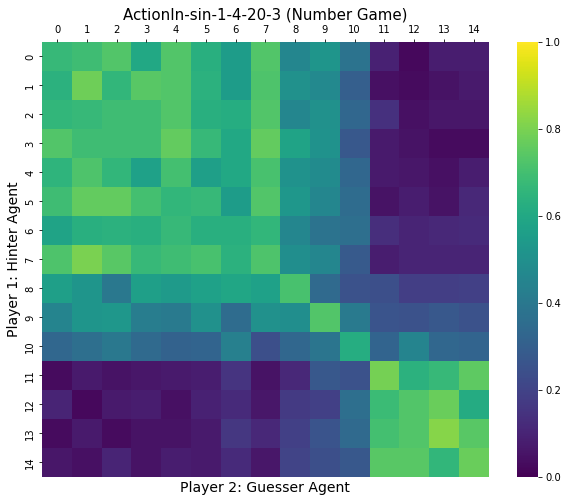

In [62]:
cmap = "viridis"
# cmap = "rocket"

fig, ax = plt.subplots(1,figsize=(10, 8))
plt.rcParams.update({'font.size': 10})
sns.heatmap(score_array, cmap=cmap, vmin=0, vmax=1)
ax.set_ylabel('Player 1: Hinter Agent', fontsize=14)
ax.set_xlabel('Player 2: Guesser Agent', fontsize=14)
ax.set_title(model_name + " (Number Game)", fontsize=15)
ax.xaxis.tick_top()

In [92]:
id = 1
sample_games(res_list[id]['p1'], res_list[id]['p2'], samples=15, print_games=True)

[ 2 10  5] [6 5 2] target: 2 hint 10 guess 2 10.0
[17  4  0] [ 6 10  4] target: 10 hint 4 guess 4 -10.0
[15  0 11] [11  7 19] target: 7 hint 0 guess 7 10.0
[ 5  0 18] [19  6  2] target: 6 hint 5 guess 6 10.0
[ 5 13 15] [ 9  5 12] target: 12 hint 5 guess 12 10.0
[14 17  6] [14  9 17] target: 9 hint 17 guess 9 10.0
[17 16  3] [12 10 19] target: 10 hint 16 guess 10 10.0
[ 1  6 15] [ 7 18 19] target: 7 hint 6 guess 18 -10.0
[ 6 13  8] [ 0  1 15] target: 1 hint 13 guess 1 10.0
[10 16 15] [ 9 19  5] target: 9 hint 15 guess 9 10.0
[ 9  5 18] [ 9 17 12] target: 9 hint 18 guess 9 10.0
[ 3 11  6] [13  0 17] target: 17 hint 6 guess 17 10.0
[14 17 14] [ 0  8 19] target: 0 hint 17 guess 19 -10.0
[ 0 10 13] [12  7  5] target: 7 hint 10 guess 7 10.0
[13  5 17] [12 14  7] target: 14 hint 13 guess 14 10.0


0.8

In [45]:
from collections import defaultdict

def get_freq(hinter, guesser, samples=1000):
    th_dict, hg_dict = np.zeros((20,20)), np.zeros((20,20))
    env = hinter.env
    for i in range(samples):
        obs_to_hinter = env.reset()
        hint_action = hinter.select_action(torch.tensor(
            obs_to_hinter, device=hinter.device), evaluate=True)
        obs_to_guesser, _, _, _ = env.step(hint_action.item())
        guess_action = guesser.select_action(torch.tensor(
            obs_to_guesser, device=hinter.device), evaluate=True)
        _, r, _, _ = env.step(guess_action)
        th_dict[env.target, env.hint] += 1/samples
        hg_dict[env.hint, env.guess] += 1/samples
    return th_dict, hg_dict


In [93]:
th_dict, hg_dict = get_freq(res_list[5]['p1'], res_list[5]['p2'], samples=5000)


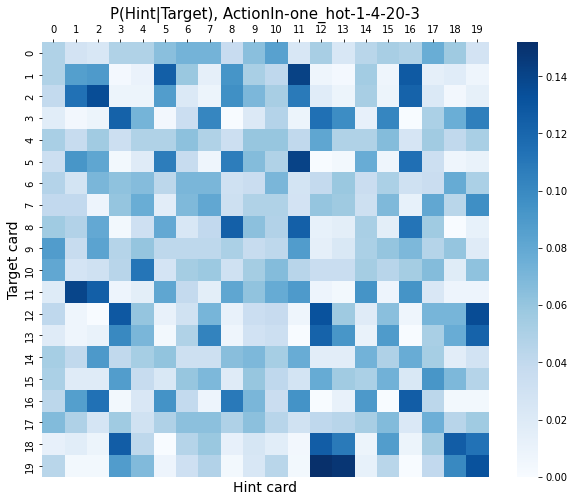

In [94]:
cmap = "viridis"
cmap = "Blues"

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.rcParams.update({'font.size': 10})
sns.heatmap(th_dict / th_dict.sum(axis=1)[:, None], cmap=cmap, vmin=0)
ax.set_ylabel('Target card', fontsize=14)
ax.set_xlabel('Hint card', fontsize=14)
ax.set_title(f"P(Hint|Target), {model_name}", fontsize=15)
ax.xaxis.tick_top()


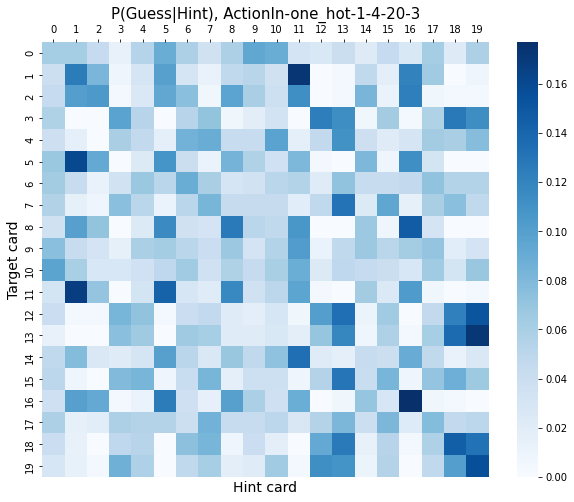

In [96]:
cmap = "viridis"
cmap = "Blues"

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.rcParams.update({'font.size': 10})
sns.heatmap(hg_dict / hg_dict.sum(axis=1)[:, None], cmap=cmap, vmin=0)
ax.set_ylabel('Target card', fontsize=14)
ax.set_xlabel('Hint card', fontsize=14)
ax.set_title(f"P(Guess|Hint), {model_name}", fontsize=15)
ax.xaxis.tick_top()


In [ ]:
sns.heatmap(hg_dict / hg_dict.sum(axis=1)[:, None], cmap=cmap, vmin=0)
